<a href="https://colab.research.google.com/github/BengiNouri/Project2/blob/main/Preprocessing%2BFE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd

car_data = pd.read_csv('/content/drive/MyDrive/car_data_raw.csv', delimiter=',', encoding='ISO-8859-1')

In [2]:
import pandas as pd

car_data['Price'] = car_data['Price'].str.replace('.', '').astype(int)

In [3]:
import pandas as pd
import numpy as np

# Make a year variable
def extract_year(x):
    if pd.notna(x):
        four_digits = x[-4:]  # Extracts the last four characters, assuming they are the year
        two_digits = x[-2:]   # Extracts the last two characters

        if four_digits.isdigit() and len(four_digits) == 4:
            return four_digits  # Return the year as is if it's four digits
        elif two_digits.isdigit() and len(two_digits) == 2:
            # Convert to four digits, assuming '20' for years 00-30 and '19' for years 31-99
            return f"20{two_digits}" if int(two_digits) <= 30 else f"19{two_digits}"
    return np.nan  # Return NaN if the year is not in the expected format or the entry is NaN

# step 1: Apply the function to create a new 'Year' column
car_data['Year'] = car_data['Production Year'].apply(extract_year).astype(float)  # Convert to float to handle NaN

# Step 2: Convert 'Year' to numeric type
car_data['Year'] = pd.to_numeric(car_data['Year'], errors='coerce')

# Step 3: Remove the 'Production Year' column
car_data = car_data.drop(columns=['Production Year'])


In [4]:
import pandas as pd

# Filter out cars produced in 2024 and before 1990
cardata = car_data[(car_data['Year'] != 2024) & (car_data['Year'] >= 1990)]

# Remove the columns 'Unnamed: 57' and 'Unnamed: 58'
cardata = cardata.drop(columns=['Unnamed: 57', 'Unnamed: 58'])

In [5]:
import pandas as pd

# Filter out ethanol cars
# Filter out rows where 'Car Name' is "Renault Twingo 1,2 16V Authentique ECO2"
cardata = cardata[cardata['Car Name'] != "Renault Twingo 1,2 16V Authentique ECO2"]

# Now cardata does not include any rows with that specific car name


In [6]:
import pandas as pd
import re

# Step 1: Separate 'Car Name' into 'Brand' and 'Model'
cardata[['Brand', 'Model']] = cardata['Car Name'].str.split(n=1, expand=True)

# Step 2: Define the cleaning function
def clean_model(row):
    brand = row['Brand']
    model = row['Model']
    if brand == "Tesla":
        # Regular expression to match Tesla models
        match = re.search(r"(Model 3|Model Y|Model S|Model X)", model)
        if match:
            return match.group(1)  # Return the matched Tesla model
        else:
            return model.split(' ')[0]  # Default to the first word of the model
    return model.split(' ')[0]  # Default case for non-Tesla brands

# Step 3: Apply the function to the DataFrame
cardata['Model'] = cardata.apply(clean_model, axis=1)
cardata.drop(columns=['Car Name'], inplace=True)

In [7]:
import pandas as pd

# Step 1: Clean 'Motor Specs' and extract new data
# Remove the first number and space (e.g., "2.5" in "2.5 Hybrid 144 kW 197 HK")
cardata['Motor_Specs_Cleaned'] = cardata['Motor Specs'].str.replace(r'^\d+\.\d+\s+', '', regex=True)

# Separate the fuel type from the remaining string (assumes fuel type is non-numeric leading characters)
cardata['Fuel_Type'] = cardata['Motor_Specs_Cleaned'].str.extract(r'^(\D+)', expand=False)

# Extract horsepower, which is the numeric value before "HK"
cardata['Horsepower'] = cardata['Motor_Specs_Cleaned'].str.extract(r'(\d+)\s?(?=HK)', expand=False)

# Step 2: Convert extracted horsepower to numeric, handling NAs
cardata['Horsepower'] = pd.to_numeric(cardata['Horsepower'], errors='coerce')

# Step 3: Select only the relevant columns to keep the dataframe tidy
# Drop the intermediate column 'Motor_Specs_Cleaned'
cardata = cardata.drop(columns=['Motor_Specs_Cleaned'])

# Now 'cardata' has the desired columns and transformations


In [8]:
category_counts = cardata['Gear'].value_counts()
print(category_counts)

# it can be seen that the 'gear' column contains some values that are not relevant.

# Transform 'Gear' based on its content
cardata['Gear'] = np.where(cardata['Gear'].str.contains('Automatgear', na=False), 'Automatgear',
                           np.where(cardata['Gear'].str.contains('Manuelt gear', na=False), 'Manuelt gear',
                                    np.nan))  # Using np.nan to represent NA in Python

category_counts2 = cardata['Gear'].value_counts()
print(category_counts2)


Gear
Automatgear                4258
Manuelt gear\n\n6-trins    2765
Manuelt gear\n\n5-trins    2312
Automatgear\n\n7-trins     2294
Automatgear\n\n6-trins     1457
Manuelt gear               1414
Automatgear\n\n8-trins     1376
Automatgear\n\n9-trins      358
Automatgear\n\n5-trins      129
Automatgear\n\n3-trins       38
Automatgear\n\n4-trins       35
Manuelt gear\n\n9-trins      24
Manuelt gear\n\n7-trins      12
Manuelt gear\n\n8-trins      12
Manuelt gear\n\n3-trins       5
Manuelt gear\n\n4-trins       4
Name: count, dtype: int64
Gear
Automatgear     9945
Manuelt gear    6548
Name: count, dtype: int64


In [9]:
import pandas as pd
import numpy as np

# Clean 'Km/L' by removing any line breaks and asterisks
cardata['Km/L'] = cardata['Km/L'].str.replace(r'\n\*', '', regex=True)

# Convert 'Km/L' to numeric, ignoring errors so non-numeric data becomes NaN
cardata['Km/L'] = pd.to_numeric(cardata['Km/L'], errors='coerce')

# Setting 'Km/L' to NaN where 'Fuel_Type' is 'EL'
cardata.loc[cardata['Fuel_Type'] == 'EL', 'Km/L'] = np.nan


In [10]:
# List of columns to be removed
# This is for feature engineering
columns_to_remove = [
    'ABS', 'Alarm', 'Aircondition', 'Alloy Rim', 'Bluetooth', 'Centrallock',
    'El-Ruder', 'El-spejle', 'Kurvelys', 'Kørecomputer', 'Multifunktionsrat',
    'Servo', 'Stop&Go', 'Vejbane Advarselssystem', 'Sport Seats', 'Reverse Camera',
    'Blindvinkelassistent', 'Digital Instrumentering', 'Electronic Trunck Opener',
    'Color', 'closest_color', 'StandardizedColor'
]

# Drop these columns
cardata = cardata.drop(columns=columns_to_remove, errors='ignore')

In [11]:
import pandas as pd

# Step 1: Counting the zeros in the 'KM Driven' column
zero_count = (cardata['KM Driven'] == 0).sum()

# Step 2: Printing the result
print(f"The number of zeros in 'Km driven' is: {zero_count}")

# Step 3: Filter out rows where 'KM Driven' is not zero
cardata = cardata[cardata['KM Driven'] != 0]


The number of zeros in 'Km driven' is: 282


In [12]:
# Look at the summary statistics for numeric variables

import pandas as pd

# Disable scientific notation for integers globally
pd.set_option('display.float_format', lambda x: '%.0f' % x)

summary_stats = cardata.describe()
print(summary_stats)


       KM Driven  Km/L   Price  Year  Horsepower
count      16211 13839   16211 16211       15980
mean       93812    22  228761  2018         168
std        80293    10  168394     5          86
min            1     5    3210  1990          15
25%        28000    17  119900  2016         110
50%        76000    21  199000  2019         150
75%       139000    24  299000  2021         204
max       700000   242 2499900  2023         996


In [13]:
# See the datatypes for all variables
import pandas as pd

data_types = cardata.dtypes
print(data_types)

KM Driven                    int64
Variant                     object
Km/L                       float64
Range (Electric)            object
Gear                        object
Motor Specs                 object
Price                        int64
GPS                         object
Trailer Hitch               object
4WD                         object
Parkingsensor               object
Cruise Control              object
Antispin                    object
ESP                         object
El-SÃ¦der                   object
Leather Interior            object
Glass Roof                  object
Headup Display              object
Isofix                      object
KlimaanlÃ¦g                 object
KÃ¸recomputer               object
Regnsensor                  object
Soltag                      object
Sports Package              object
Seatwarmer                  object
Xenon Lights                object
Non-Smoker                  object
One-Owner                   object
Service OK          

In [14]:
# Count the number of occurrences of each brand
brand_counts = cardata['Brand'].value_counts()

# Print the result
print(brand_counts)

Brand
VW            2297
Mercedes      1514
Peugeot       1132
Skoda         1105
Audi          1075
Ford          1028
BMW            883
Renault        786
CitroÃ«n       642
Opel           568
Hyundai        554
Kia            544
Nissan         502
Volvo          460
Toyota         397
Seat           395
Suzuki         318
Fiat           298
Mazda          282
Tesla          264
Dacia          133
Cupra          126
Mini           125
Polestar       105
Mitsubishi      98
Porsche         95
MG              81
Honda           75
Chevrolet       60
Jaguar          60
Alfa            44
Land            35
Jeep            29
Subaru          21
Lexus           16
Dodge           12
Maserati        11
Ferrari         10
Saab             8
Lotus            7
Chrysler         7
Rover            5
Cadillac         3
Pontiac          1
Name: count, dtype: int64


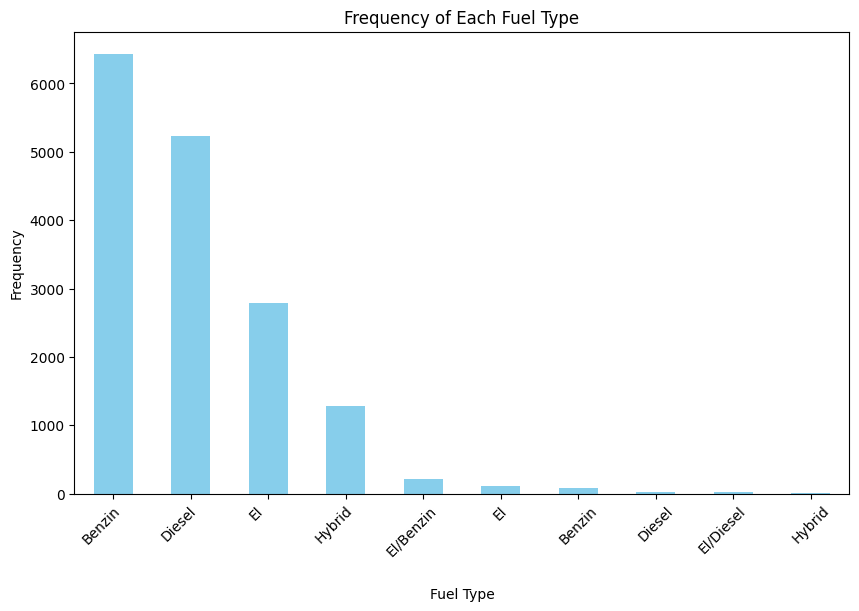

In [15]:
# plot fuel_type
import matplotlib.pyplot as plt
# Count the occurrences of each category in 'Fuel_Type'
fuel_type_counts = cardata['Fuel_Type'].value_counts()

# Create a bar plot using matplotlib
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
fuel_type_counts.plot(kind='bar', color='skyblue')
plt.title('Frequency of Each Fuel Type')
plt.xlabel('Fuel Type')
plt.ylabel('Frequency')
plt.xticks(rotation=45)  # Rotate the labels for better readability
plt.show()

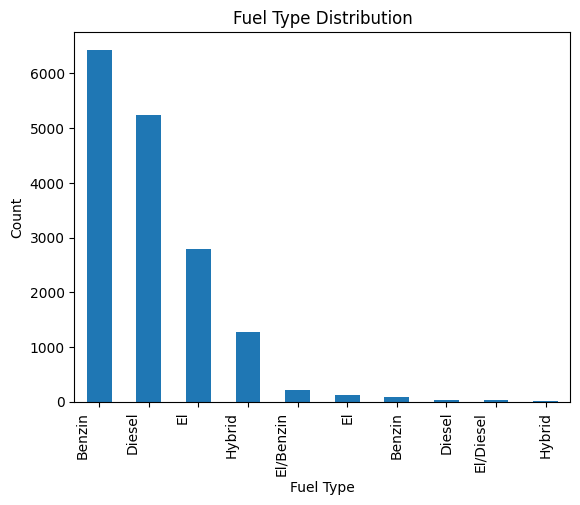

In [16]:
import matplotlib.pyplot as plt

# Assuming 'cardata' is your DataFrame and it's already loaded
# Example: cardata = pd.DataFrame({'Fuel_type': ['Gas', 'EL', 'Diesel'], 'Km/L': ['123\n*', '150*', '140\n']})

# Plotting a bar chart for 'Fuel_type'
cardata['Fuel_Type'].value_counts().plot(kind='bar')
plt.xlabel('Fuel Type')
plt.ylabel('Count')
plt.title('Fuel Type Distribution')
plt.show()


In [13]:
import pandas as pd

# Assuming 'cardata' is your DataFrame and it's already loaded
# Example: cardata = pd.DataFrame({'Fuel_Type': ['El', 'El/Diesel', 'Diesel', 'Benzin\n', 'Hybrid ', 'El/Benzin']})

# Remove newlines and trim white spaces from the 'Fuel_Type' column
cardata['Fuel_Type'] = cardata['Fuel_Type'].str.replace("\\n", "", regex=True).str.strip()

# Function to standardize the 'Fuel_Type' column based on conditions
def standardize_fuel_type(fuel_type):
    if 'Hybrid' in fuel_type or 'El/Diesel' in fuel_type or 'El/Benzin' in fuel_type:
        return 'Hybrid'
    elif 'El' in fuel_type:
        return 'El'
    elif 'Diesel' in fuel_type:
        return 'Diesel'
    elif 'Benzin' in fuel_type:
        return 'Benzin'
    else:
        return fuel_type

# Apply the function to the 'Fuel_Type' column
cardata['Fuel_Type'] = cardata['Fuel_Type'].apply(standardize_fuel_type)


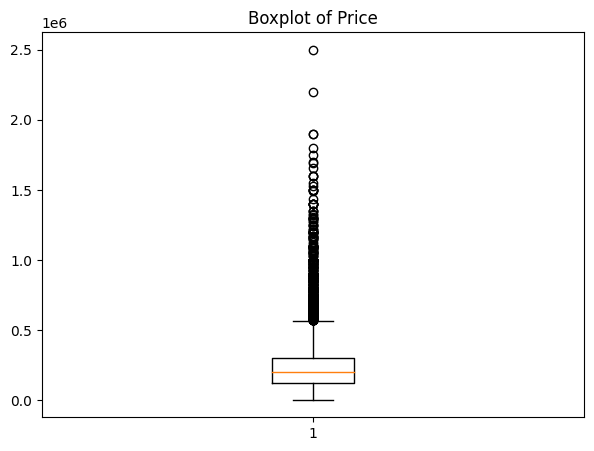

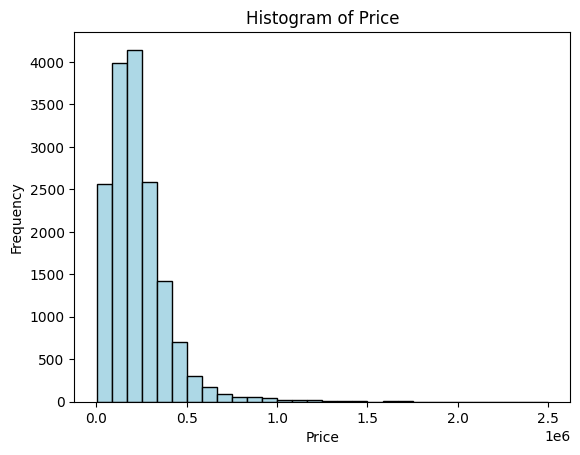

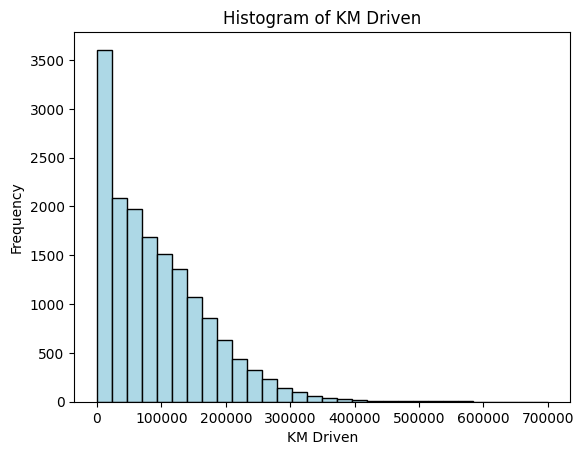

In [18]:
import matplotlib.pyplot as plt
# Create boxplots to visualize outliers in numerical variables
fig, axs = plt.subplots(figsize=(7,5))
axs.boxplot(cardata["Price"])
axs.set_title("Boxplot of Price")
plt.show()

# Create a histogram of the 'Price' column
plt.hist(cardata['Price'], bins=30, color='lightblue', edgecolor='black')  # You can adjust the number of bins and color
plt.title('Histogram of Price')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

# Create a histogram of the 'KM Driven' column
plt.hist(cardata['KM Driven'], bins=30, color='lightblue', edgecolor='black')  # You can adjust the number of bins and color
plt.title('Histogram of KM Driven')
plt.xlabel('KM Driven')
plt.ylabel('Frequency')
plt.show()

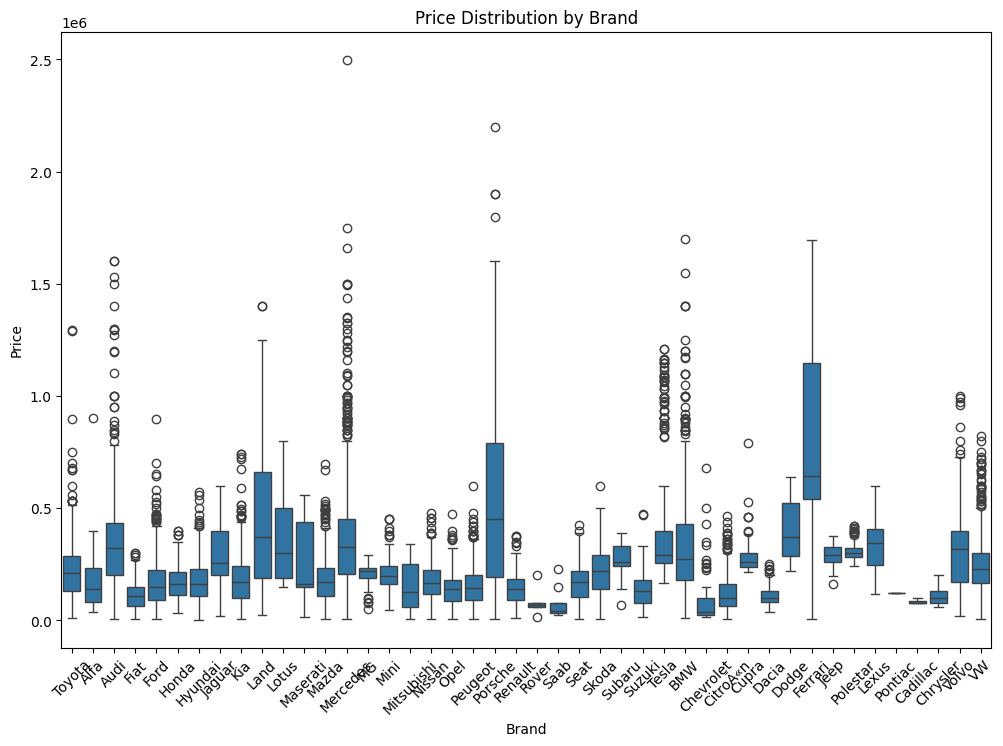

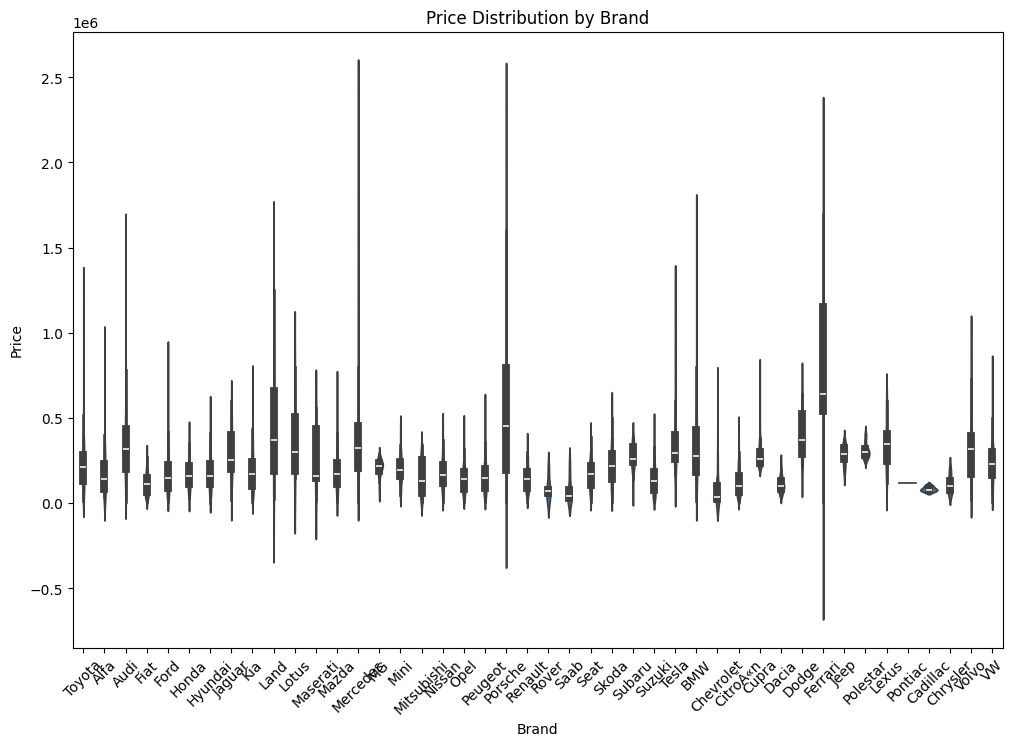

In [19]:
import seaborn as sns

# Seaborn boxplot
plt.figure(figsize=(12, 8))
sns.boxplot(x='Brand', y='Price', data=cardata)
plt.title('Price Distribution by Brand')
plt.xlabel('Brand')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.show()

# Seaborn violin plot
plt.figure(figsize=(12, 8))
sns.violinplot(x='Brand', y='Price', data=cardata)
plt.title('Price Distribution by Brand')
plt.xlabel('Brand')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.show()


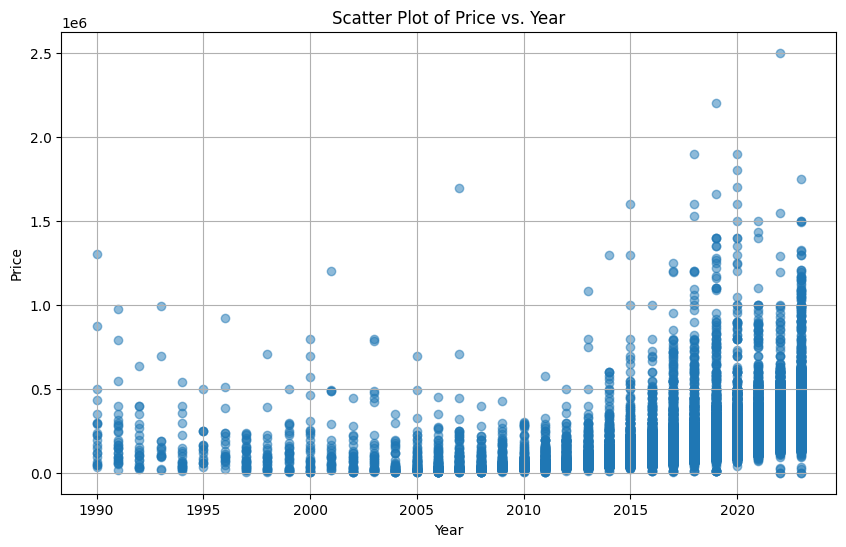

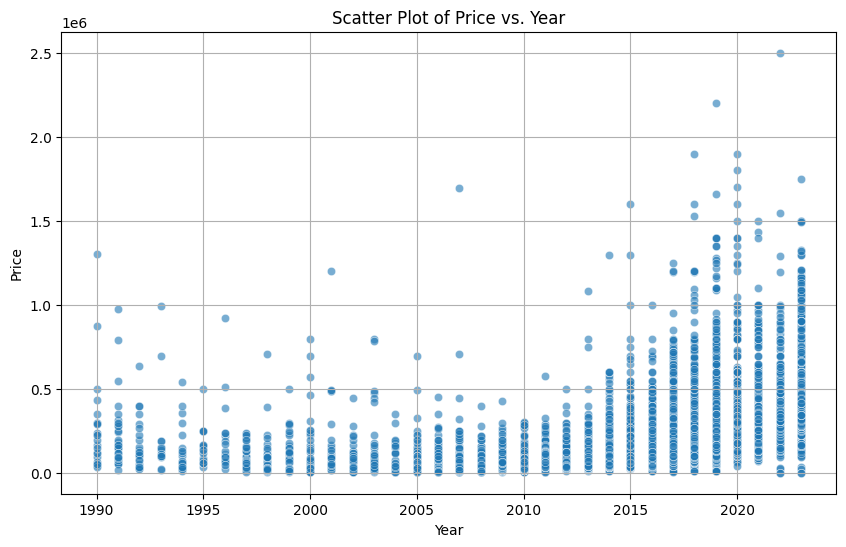

In [20]:
import matplotlib.pyplot as plt

# Assuming cardata is your DataFrame
# Create a scatter plot using matplotlib
plt.figure(figsize=(10, 6))  # Adjust the size as needed
plt.scatter(cardata['Year'], cardata['Price'], alpha=0.5)  # alpha is used to adjust the transparency
plt.title('Scatter Plot of Price vs. Year')
plt.xlabel('Year')
plt.ylabel('Price')
plt.grid(True)  # Adds a grid for better readability
plt.show()

import seaborn as sns

# Create a scatter plot using seaborn
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Year', y='Price', data=cardata, alpha=0.6)  # Seaborn with more aesthetic defaults
plt.title('Scatter Plot of Price vs. Year')
plt.xlabel('Year')
plt.ylabel('Price')
plt.grid(True)  # Adds a grid
plt.show()



In [21]:
# Looking at correlation between price and other variables
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# Select the subset of data including only the columns of interest
cor_data = cardata[['Price', 'KM Driven', 'Horsepower', 'Year']]

# Calculate the correlation matrix
correlation_matrix = cor_data.corr()
print(correlation_matrix)

            Price  KM Driven  Horsepower  Year
Price           1         -0           1     0
KM Driven      -0          1          -0    -1
Horsepower      1         -0           1     0
Year            0         -1           0     1


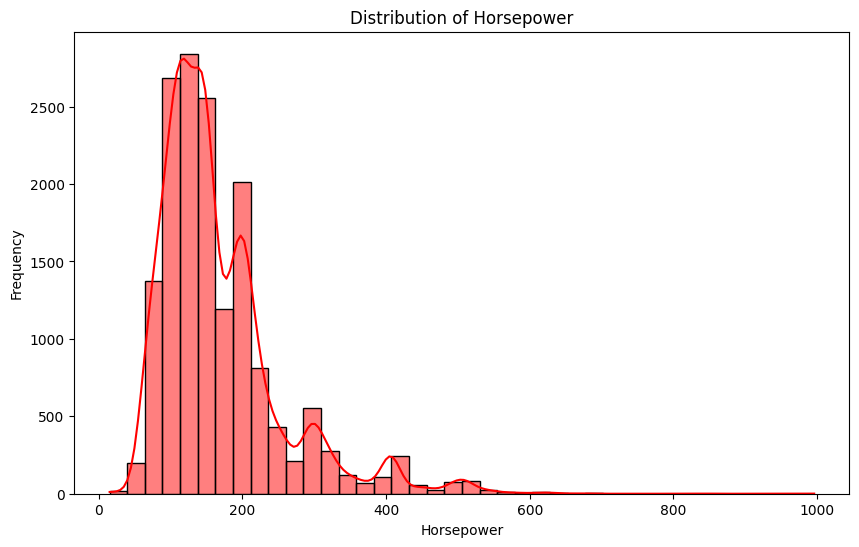

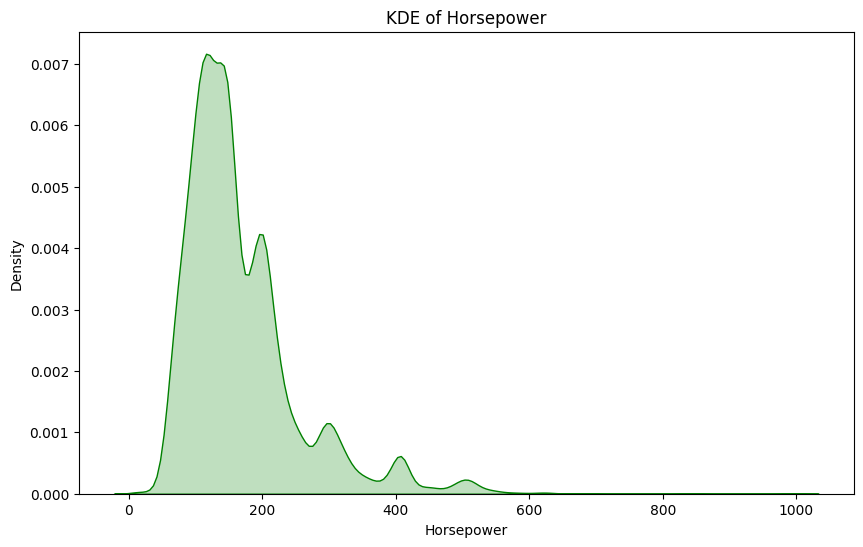

In [22]:
import seaborn as sns

# Create a histogram with a KDE (Kernel Density Estimate)
plt.figure(figsize=(10, 6))
sns.histplot(cardata['Horsepower'], bins=40, kde=True, color='red')  # color and bins can be adjusted
plt.title('Distribution of Horsepower')
plt.xlabel('Horsepower')
plt.ylabel('Frequency')
plt.show()

# Alternatively, just a KDE plot for a smoother distribution curve
plt.figure(figsize=(10, 6))
sns.kdeplot(cardata['Horsepower'], color='green', fill=True)  # 'fill' fills the area under the KDE curve
plt.title('KDE of Horsepower')
plt.xlabel('Horsepower')
plt.ylabel('Density')
plt.show()


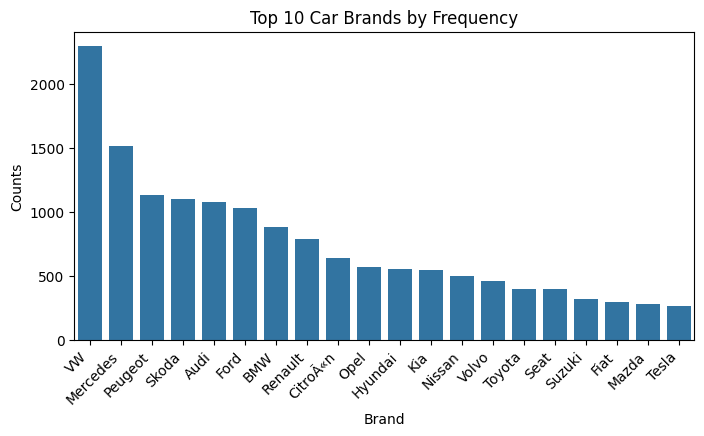

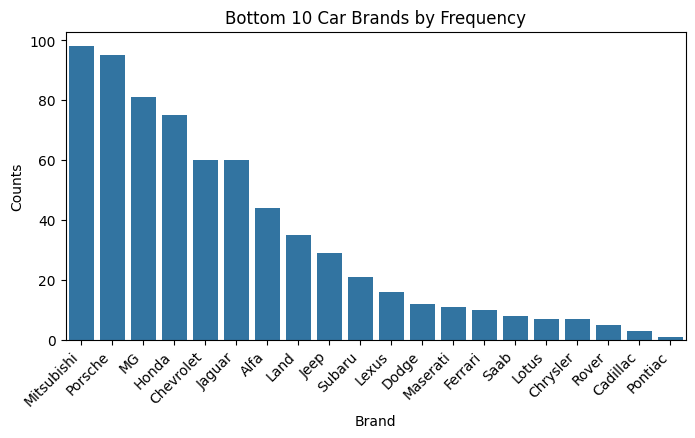

In [23]:
# Show distribution of brands
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate frequency of each brand
brand_counts = cardata['Brand'].value_counts().reset_index()
brand_counts.columns = ['Brand', 'Count']

# Get top 20 and bottom 20 brands
top_10_brands = brand_counts.head(20)
bottom_10_brands = brand_counts.tail(20)

# Plotting
plt.figure(figsize=(8, 4))
barplot = sns.barplot(data=top_10_brands, x='Brand', y='Count')
plt.xticks(rotation=45, ha='right')  # Rotate brand names for better visibility
plt.title('Top 10 Car Brands by Frequency')
plt.ylabel('Counts')
plt.xlabel('Brand')

# Show the plot
plt.show()

# Plotting
plt.figure(figsize=(8, 4))
barplot = sns.barplot(data=bottom_10_brands, x='Brand', y='Count')
plt.xticks(rotation=45, ha='right')  # Rotate brand names for better visibility
plt.title('Bottom 10 Car Brands by Frequency')
plt.ylabel('Counts')
plt.xlabel('Brand')

# Show the plot
plt.show()



In [24]:
cardata['Variant'] = cardata['Variant'].replace('-', np.nan)

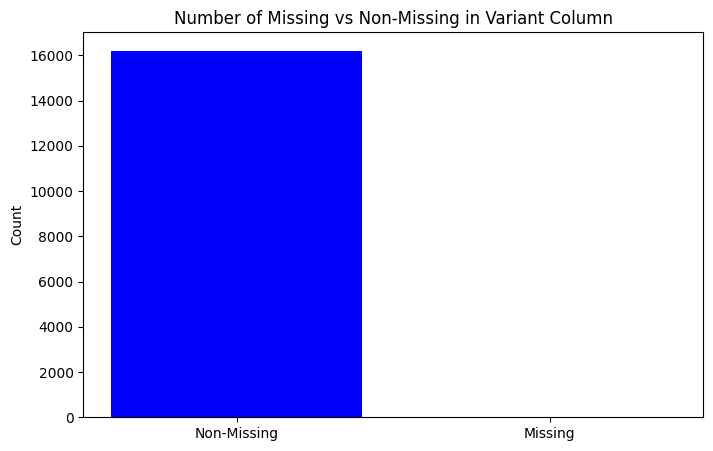

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'cardata' is your DataFrame
# Calculate missing and non-missing counts
missing_count = cardata['Variant'].isna().sum()  # Number of missing values
non_missing_count = cardata['Variant'].notna().sum()  # Number of non-missing values

# Prepare data for plotting
counts = [non_missing_count, missing_count]
labels = ['Non-Missing', 'Missing']

# Create a bar plot
plt.figure(figsize=(8, 5))
plt.bar(labels, counts, color=['blue', 'red'])
plt.title('Number of Missing vs Non-Missing in Variant Column')
plt.ylabel('Count')
plt.show()


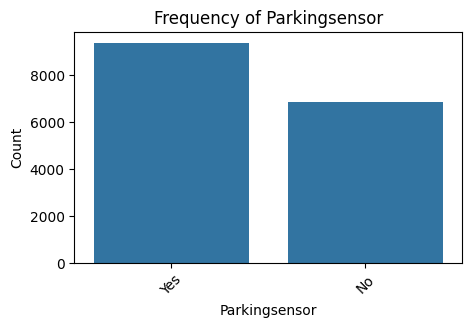

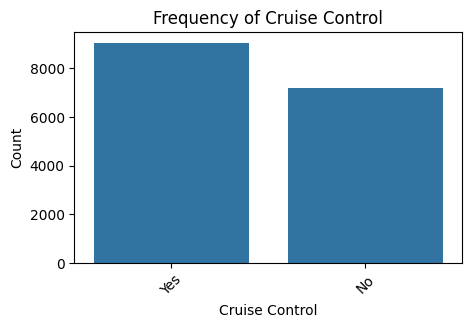

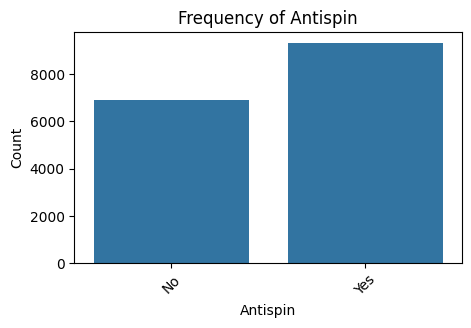

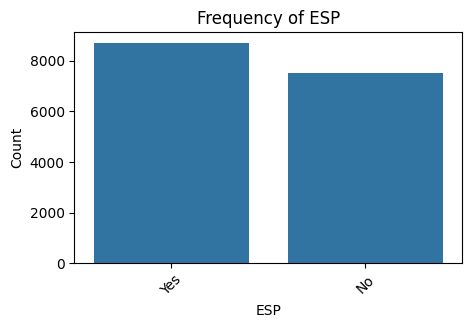

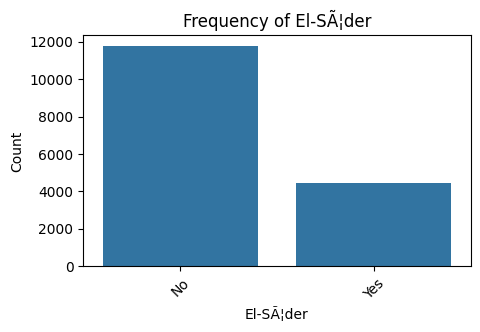

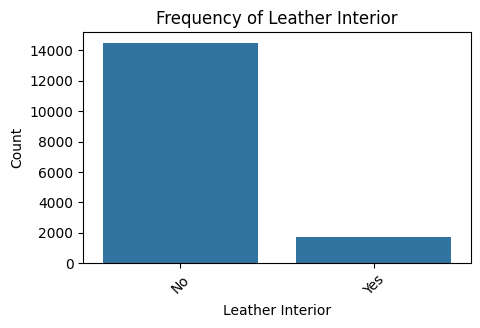

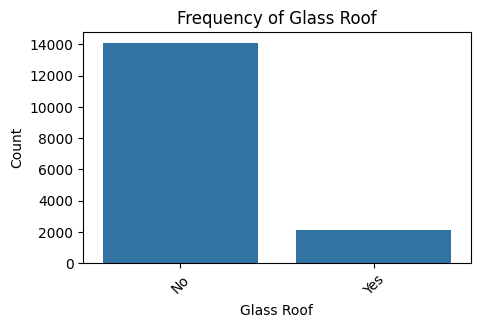

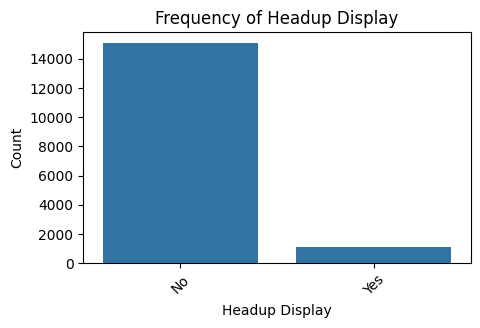

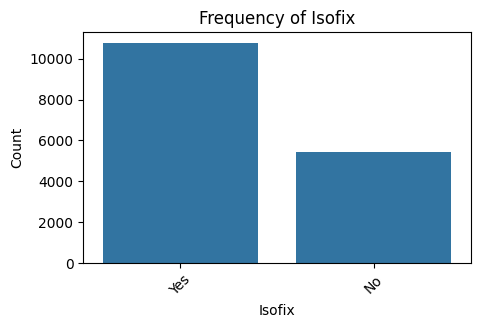

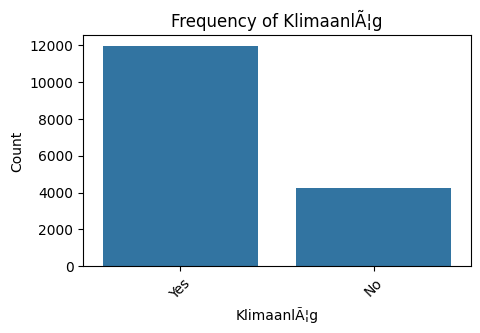

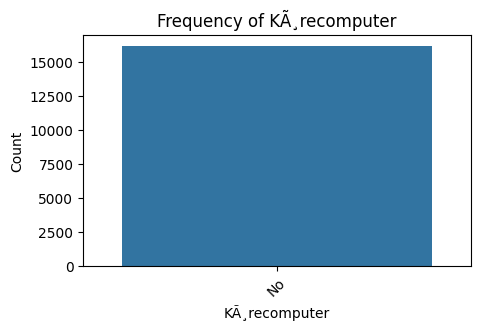

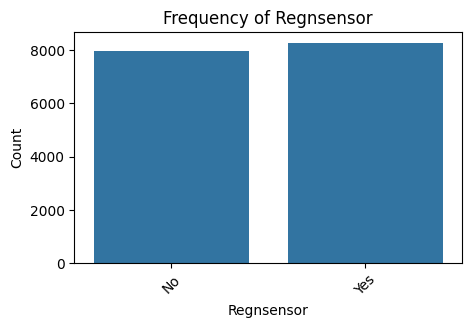

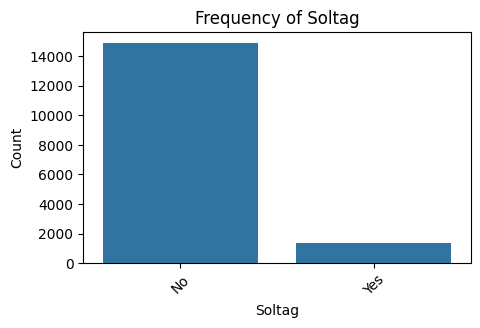

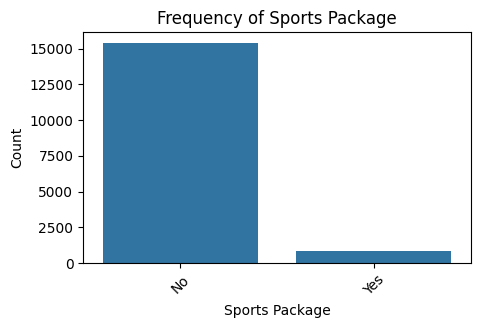

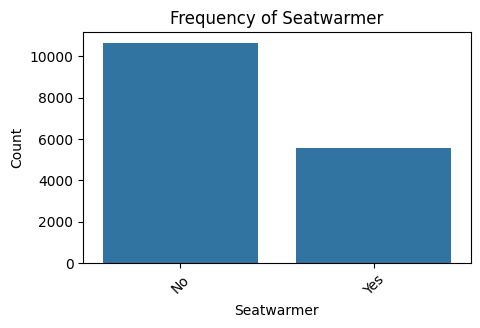

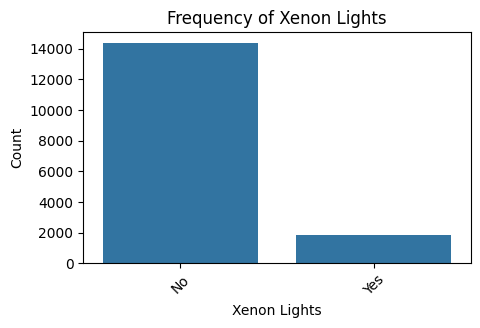

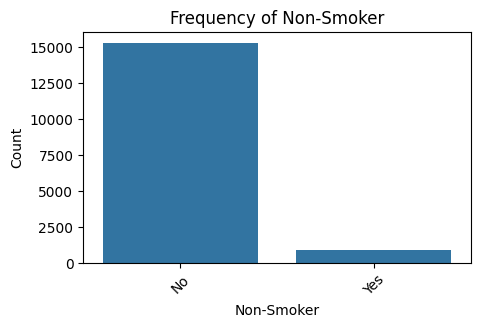

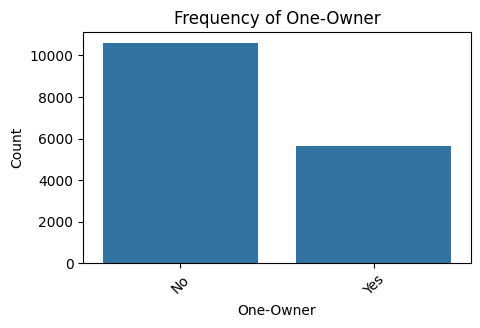

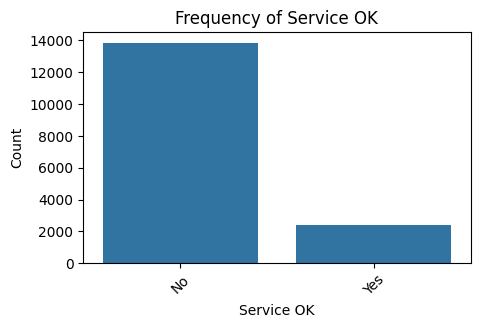

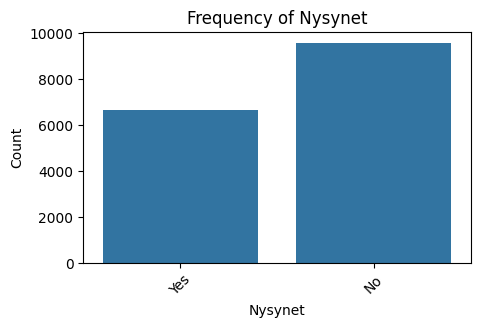

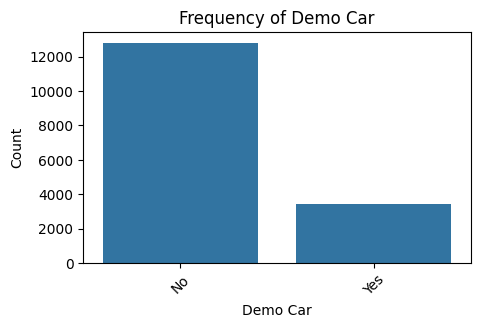

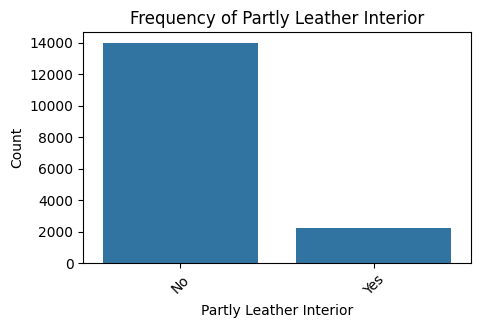

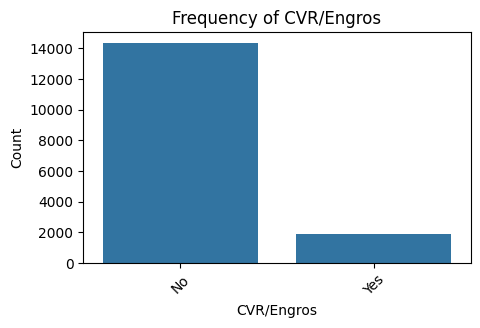

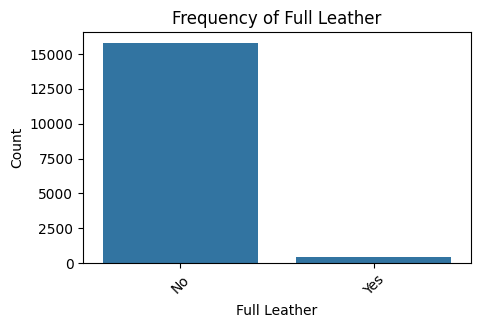

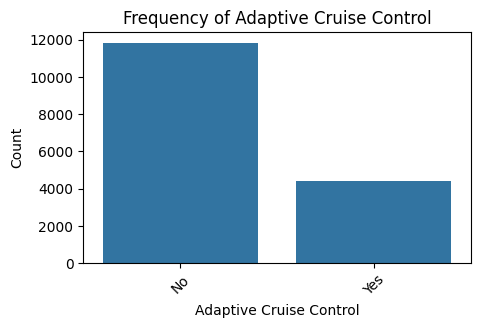

KeyboardInterrupt: 

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting each specified categorical column using seaborn
for column in cardata.columns[10:36]:  # Adjust the indices to Python's 0-based index if necessary
    plt.figure(figsize=(5, 3))  # Adjust the figure size as needed
    sns.countplot(x=cardata[column])
    plt.title(f'Frequency of {column}')
    plt.ylabel('Count')
    plt.xlabel(column)
    plt.xticks(rotation=45)  # Rotate labels if they are too cramped or not readable
    plt.show()

In [16]:
# Sample DataFrame loading, replace with your actual data loading method
# cardata = pd.read_csv('path_to_your_data.csv')

def remove_outliers(group):
    q1 = group['Price'].quantile(0.25)
    q3 = group['Price'].quantile(0.75)
    iqr = q3 - q1
    upper = q3 + 1.5 * iqr
    lower = q1 - 1.5 * iqr
    return group[(group['Price'] < upper) & (group['Price'] > lower)]

# Apply the function to each brand group
cardata = cardata.groupby('Brand').apply(remove_outliers).reset_index(drop=True)



In [17]:
# Assuming the column of interest is named 'Variant'
variant_counts = cardata['Variant'].value_counts()

# Printing the count of each category in the 'Variant' column
print(variant_counts)

# Optionally, create a table for better visualization
table = pd.DataFrame(variant_counts)
table.reset_index(inplace=True)
table.columns = ['Variant', 'Count']
print(table)

Variant
-                        3593
Style                     703
AMG line                  483
Comfortline               369
Active                    363
                         ... 
AMG Line Premium Plus       1
Skyview Edition             1
XLi                         1
Touch                       1
Vogue                       1
Name: count, Length: 360, dtype: int64
                   Variant  Count
0                        -   3593
1                    Style    703
2                 AMG line    483
3              Comfortline    369
4                   Active    363
..                     ...    ...
355  AMG Line Premium Plus      1
356        Skyview Edition      1
357                    XLi      1
358                  Touch      1
359                  Vogue      1

[360 rows x 2 columns]


In [18]:
cardata.drop(columns=['Motor Specs'], inplace=True)
columns_to_replace = ['GPS', 'Trailer Hitch', '4WD', 'Parkingsensor', 'Cruise Control', 'Antispin', 'ESP', 'El-SÃ¦der', 'Leather Interior', 'Glass Roof', 'Headup Display', 'Isofix', 'KlimaanlÃ¦g', 'Regnsensor', 'Soltag', 'Sports Package', 'Seatwarmer', 'Xenon Lights', 'Non-Smoker', 'One-Owner', 'Service OK', 'Nysynet', 'Demo Car', 'Partly Leather Interior', 'CVR/Engros', 'Full Leather', 'Adaptive Cruise Control']  # Specify the columns you want to replace values in
cardata[columns_to_replace] = cardata[columns_to_replace].replace({'Yes': 1, 'No': 0})

In [19]:
# Drop the 'Variant' column from the DataFrame
cardata = cardata.drop('Variant', axis=1)
# Check the remaining columns in the DataFrame
print(cardata.columns)

Index(['KM Driven', 'Km/L', 'Range (Electric)', 'Gear', 'Price', 'GPS',
       'Trailer Hitch', '4WD', 'Parkingsensor', 'Cruise Control', 'Antispin',
       'ESP', 'El-SÃ¦der', 'Leather Interior', 'Glass Roof', 'Headup Display',
       'Isofix', 'KlimaanlÃ¦g', 'KÃ¸recomputer', 'Regnsensor', 'Soltag',
       'Sports Package', 'Seatwarmer', 'Xenon Lights', 'Non-Smoker',
       'One-Owner', 'Service OK', 'Nysynet', 'Demo Car',
       'Partly Leather Interior', 'CVR/Engros', 'Full Leather',
       'Adaptive Cruise Control', 'Link', 'Year', 'Brand', 'Model',
       'Fuel_Type', 'Horsepower'],
      dtype='object')


In [20]:
# Count occurrences of each value in the 'Km/L' column including NaN values
km_per_l_counts = cardata['Km/L'].value_counts(dropna=False)

# Print the count of each category in the 'Km/L' column
print(km_per_l_counts)

Km/L
NaN    2265
23      418
20      365
20      316
24      311
       ... 
101       1
69        1
43        1
97        1
5         1
Name: count, Length: 428, dtype: int64


In [21]:
# If 'range (Electric)' is correctly listed among the columns, count its values
if 'Range (Electric)' in cardata.columns:
    range_counts = cardata['Range (Electric)'].value_counts(dropna=False)
    print(range_counts)
else:
    print("Column 'Range (Electric)' does not exist in DataFrame.")

Range (Electric)
NaN       13094
424 Km       88
537 Km       70
411 Km       54
429 Km       54
          ...  
527 Km        1
574 Km        1
339 Km        1
612 Km        1
579 Km        1
Name: count, Length: 249, dtype: int64


In [22]:
cardata['Range (Electric)'] = pd.to_numeric(cardata['Range (Electric)'].str.replace(' Km', ''), errors='coerce')

km_per_l_mean = cardata.groupby(['Brand', 'Fuel_Type'])['Km/L'].transform('mean')
range_electric_mean = cardata.groupby(['Brand', 'Fuel_Type'])['Range (Electric)'].transform('mean')

# Replace NaN values with the mean of their respective brands using .loc
cardata['Km/L'] = cardata['Km/L'].fillna(km_per_l_mean)
cardata['Range (Electric)'] = cardata['Range (Electric)'].fillna(range_electric_mean)

cardata['Km/L'] = cardata['Km/L'].fillna(cardata['Km/L'].mean())
cardata['Range (Electric)'] = cardata['Range (Electric)'].fillna(cardata['Range (Electric)'].mean())

print(cardata[['Brand', 'Model', 'Km/L', 'Range (Electric)']].head())

  Brand  Model  Km/L  Range (Electric)
0  Alfa  Romeo    21               436
1  Alfa  Romeo    17               436
2  Alfa  Romeo    18               436
3  Alfa  Romeo    15               436
4  Alfa  Romeo    13               436


In [23]:
# Convert numeric columns
# Assuming 'KM Driven', 'Km/L', 'Range (Electric)', 'Price', and 'Horsepower' should be numeric
numeric_columns = ['KM Driven', 'Km/L', 'Range (Electric)', 'Price', 'Horsepower']
for col in numeric_columns:
    cardata[col] = pd.to_numeric(cardata[col], errors='coerce')  # 'coerce' converts errors to NaN

# Convert factor-like columns
# Assuming all other object type columns should be treated as categorical
factor_columns = [col for col in cardata.columns if cardata[col].dtype == 'object']
for col in factor_columns:
    cardata[col] = cardata[col].astype('category')

# Verify changes
print(cardata.dtypes)

KM Driven                     int64
Km/L                        float64
Range (Electric)            float64
Gear                       category
Price                         int64
GPS                           int64
Trailer Hitch                 int64
4WD                           int64
Parkingsensor                 int64
Cruise Control                int64
Antispin                      int64
ESP                           int64
El-SÃ¦der                     int64
Leather Interior              int64
Glass Roof                    int64
Headup Display                int64
Isofix                        int64
KlimaanlÃ¦g                   int64
KÃ¸recomputer              category
Regnsensor                    int64
Soltag                        int64
Sports Package                int64
Seatwarmer                    int64
Xenon Lights                  int64
Non-Smoker                    int64
One-Owner                     int64
Service OK                    int64
Nysynet                     

In [24]:
# Round 'Km/L' and 'Range (Electric)' to no decimal places
cardata['Km/L'] = cardata['Km/L'].round(0)
cardata['Range (Electric)'] = cardata['Range (Electric)'].round(0)
# Print some of the data to verify the rounding
print(cardata[['Brand', 'Model', 'Km/L', 'Range (Electric)']].head())

  Brand  Model  Km/L  Range (Electric)
0  Alfa  Romeo    21               436
1  Alfa  Romeo    17               436
2  Alfa  Romeo    18               436
3  Alfa  Romeo    15               436
4  Alfa  Romeo    13               436


In [25]:
# Count NaN values in each column
na_count = cardata.isna().sum()

# Print the count of NaNs for each column
print(na_count)

# Optionally, if you want to see the total number of NaNs in the entire dataset
total_na = cardata.isna().sum().sum()
print("Total NaN values in the dataset:", total_na)

KM Driven                    0
Km/L                         0
Range (Electric)             0
Gear                         0
Price                        0
GPS                          0
Trailer Hitch                0
4WD                          0
Parkingsensor                0
Cruise Control               0
Antispin                     0
ESP                          0
El-SÃ¦der                    0
Leather Interior             0
Glass Roof                   0
Headup Display               0
Isofix                       0
KlimaanlÃ¦g                  0
KÃ¸recomputer                0
Regnsensor                   0
Soltag                       0
Sports Package               0
Seatwarmer                   0
Xenon Lights                 0
Non-Smoker                   0
One-Owner                    0
Service OK                   0
Nysynet                      0
Demo Car                     0
Partly Leather Interior      0
CVR/Engros                   0
Full Leather                 0
Adaptive

In [26]:
# Calculate the mean 'Horsepower' for each 'Brand'
brand_mean_horsepower = cardata.groupby(['Brand', 'Fuel_Type'])['Horsepower'].transform('mean')

# Impute missing 'Horsepower' values with the mean 'Horsepower' of their respective brand
cardata['Horsepower'] = cardata['Horsepower'].fillna(brand_mean_horsepower)

# Since the mean could be NaN if a brand's all Horsepower values are NaN, optionally handle these
# by replacing any remaining NaNs with the overall mean of the 'Horsepower' across all brands
overall_mean_horsepower = cardata['Horsepower'].mean()
cardata['Horsepower'] = cardata['Horsepower'].fillna(overall_mean_horsepower)

# Print some of the data to verify
print(cardata[['Brand', 'Model', 'Horsepower']].head())

  Brand  Model  Horsepower
0  Alfa  Romeo         180
1  Alfa  Romeo         170
2  Alfa  Romeo         170
3  Alfa  Romeo         240
4  Alfa  Romeo         235


In [44]:
car_data_dbh = cardata[cardata['Fuel_Type'].isin(['Benzin', 'Diesel', 'Hybrid'])]
car_data_dbh = car_data_dbh.drop(columns=['Range (Electric)'])
car_data_el = cardata[cardata['Fuel_Type'] == 'El']


car_data_dbh.to_csv('car_data_dbh.csv', index=False)
car_data_el.to_csv('car_data_el.csv', index=False)
